<a href="https://colab.research.google.com/github/TiffanyNgai/Human-tracking/blob/main/Human_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contribution:
- Osose Itua
- Ali Ayub
- Tiffany Ngai

#Set up

In [ ]:
from sklearn.cluster import KMeans
from google.colab import drive
import numpy as np
from PIL import Image;
import cv2
from google.colab.patches import cv2_imshow
import os
import torch
import torch.nn
import torchvision
from torchvision import models, transforms
import torch
import torch.nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Machine learning projects/Human tracking/video.avi"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing

In [ ]:
# Crop sampled frames
roi1_region = (502, 344, 61, 86) 
roi2_region = (627, 427, 193, 93) 
roi3_region = (522, 654, 90, 85) 
roi4_region = (704, 594, 90, 80) 
roi5_region = (545, 577, 81, 75)
roi6_region = (460, 700, 52, 80)

X_roi1 = []
X_roi2 = []
X_roi3 = []
X_roi4 = []
X_roi5 = []
X_roi6 = []

for i, icurrentframe in enumerate(range(0, 13501, 1)):
    image = cv2.imread('/content/drive/MyDrive/Machine learning projects/Human tracking/video_frames/frame' + str(icurrentframe) + '.jpg');
    roi1 = image[344:430, 502:563, :]
    roi2 = image[427:520, 627:820, :]
    roi3 = image[654:739, 522:612, :]
    roi4 = image[594:647, 704:794, :]
    roi5 = image[577:652, 545:626, :]
    roi6 = image[700:780, 460:512, :]
    X_roi1.append(roi1)
    X_roi2.append(roi2)
    X_roi3.append(roi3)
    X_roi4.append(roi4)
    X_roi5.append(roi5)
    X_roi6.append(roi6)
    cv2.imwrite('/content/drive/MyDrive/Machine learning projects/Human tracking/ROI1/Frame' + str(icurrentframe) + '.jpg', roi1);
    cv2.imwrite('/content/drive/MyDrive/Machine learning projects/Human tracking/ROI2/Frame' + str(icurrentframe) + '.jpg', roi2);
    cv2.imwrite('/content/drive/MyDrive/Machine learning projects/Human tracking/ROI3/Frame' + str(icurrentframe) + '.jpg', roi3);
    cv2.imwrite('/content/drive/MyDrive/Machine learning projects/Human tracking/ROI4/Frame' + str(icurrentframe) + '.jpg', roi4);
    cv2.imwrite('/content/drive/MyDrive/Machine learning projects/Human tracking/ROI5/Frame' + str(icurrentframe) + '.jpg', roi5);
    cv2.imwrite('/content/drive/MyDrive/Machine learning projects/Human tracking/ROI6/Frame' + str(icurrentframe) + '.jpg', roi6);


In [ ]:
# Convert list to np array
X_roi1 = np.array(X_roi1)
X_roi2 = np.array(X_roi2)
X_roi3 = np.array(X_roi3)
X_roi4 = np.array(X_roi4)
X_roi5 = np.array(X_roi5)
X_roi6 = np.array(X_roi6)

print(X_roi1.shape)

(901, 86, 61, 3)
(901, 15738)


In [ ]:
cuda0 = torch.device('cpu')#('cuda:0')
model = torchvision.models.resnet18(pretrained=True)
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
newmodel.to(cuda0)
newmodel.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class getTransformedData(Dataset):
    """transformed dataset
    """
    def __init__(self, images, transform=None):
        self.train_images = images
        self.train_images = np.array(self.train_images)
        #if transform is given, we transoform data using
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, index):
        image = self.train_images[index]
        if self.transform:
            image = self.transform(np.uint8(image))
        return image

my_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,.456,.406],
                                 std=[.229,.224,.225])
        ])

In [ ]:
# Generate feature vectors
X_roi1_fv = []
X_roi2_fv = []
X_roi3_fv = []
X_roi4_fv = []
X_roi5_fv = []
X_roi6_fv = []

for i in range(len(X_roi1)):
  images = X_roi1[i]
  images = my_transforms(images)
  images = torch.unsqueeze(images,0)
  images = images.to(cuda0)
  out = newmodel(images)
  out = out.view(-1,)
  X_roi1_fv.append(out.detach().numpy())
X_roi1_fv = np.array(X_roi1_fv)
print (X_roi1_fv.shape)

for i in range(len(X_roi2)):
  images = X_roi2[i]
  images = my_transforms(images)
  images = torch.unsqueeze(images,0)
  images = images.to(cuda0)
  out = newmodel(images)
  out = out.view(-1,)
  X_roi2_fv.append(out.detach().numpy())
X_roi2_fv = np.array(X_roi2_fv)
print (X_roi2_fv.shape)

for i in range(len(X_roi3)):
  images = X_roi3[i]
  images = my_transforms(images)
  images = torch.unsqueeze(images,0)
  images = images.to(cuda0)
  out = newmodel(images)
  out = out.view(-1,)
  X_roi3_fv.append(out.detach().numpy())
X_roi3_fv = np.array(X_roi3_fv)
print (X_roi3_fv.shape)

for i in range(len(X_roi4)):
  images = X_roi4[i]
  images = my_transforms(images)
  images = torch.unsqueeze(images,0)
  images = images.to(cuda0)
  out = newmodel(images)
  out = out.view(-1,)
  X_roi4_fv.append(out.detach().numpy())
X_roi4_fv = np.array(X_roi4_fv)
print (X_roi4_fv.shape)

for i in range(len(X_roi5)):
  images = X_roi5[i]
  images = my_transforms(images)
  images = torch.unsqueeze(images,0)
  images = images.to(cuda0)
  out = newmodel(images)
  out = out.view(-1,)
  X_roi5_fv.append(out.detach().numpy())
X_roi5_fv = np.array(X_roi5_fv)
print (X_roi5_fv.shape)

for i in range(len(X_roi6)):
  images = X_roi6[i]
  images = my_transforms(images)
  images = torch.unsqueeze(images,0)
  images = images.to(cuda0)
  out = newmodel(images)
  out = out.view(-1,)
  X_roi6_fv.append(out.detach().numpy())
X_roi6_fv = np.array(X_roi6_fv)
print (X_roi6_fv.shape)

(901, 512)
(901, 512)
(901, 512)
(901, 512)
(901, 512)
(901, 512)


#Clustering

In [130]:
# Clustering - ROI1 - TODO: Try sklearn.mixture.GaussianMixture
N_CLUSTER = 2
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X_roi1_fv)
roi1_result = kmeans.labels_

In [131]:
# Clustering - ROI2
N_CLUSTER = 3
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X_roi2_fv)
roi2_result = kmeans.labels_

In [132]:
# Clustering - ROI3
N_CLUSTER = 2
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X_roi3_fv)
roi3_result = kmeans.labels_

In [133]:
# Clustering - ROI4
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X_roi4_fv)
roi4_result = kmeans.labels_

In [134]:
# Clustering - ROI5
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X_roi5_fv)
roi5_result = kmeans.labels_

In [135]:
# Clustering - ROI6
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X_roi6_fv)
roi6_result = kmeans.labels_

In [149]:
#Print a couple images per class for visual inspection
def visualizeClusters(result):
  num_clusters = len(np.unique(result))
  clusters_ind = [[] for _ in range(num_clusters)]
  for i in range(len(result)):
    for icluster in range(num_clusters):
      if result[i] == icluster:
        clusters_ind[icluster].append(i)  # save index
  return clusters_ind

In [150]:
def findCov(clusters):
  cov = np.zeros((len(clusters),))
  for icluster in range(len(clusters)):
    cov[icluster] = np.var(feature_vector[clusters[icluster]]) 
  return cov

In [151]:
feature_vector = X_roi1_fv
cluster1 = visualizeClusters(roi1_result)
print(findCov(cluster1))
print(len(cluster1[0]))
print(len(cluster1[1]))

[0.65799302 0.68790579]
297
604


In [152]:
feature_vector = X_roi2_fv
cluster2 = visualizeClusters(roi2_result)
print(findCov(cluster2))
print(len(cluster2[0]))
print(len(cluster2[1]))
print(len(cluster2[2]))

[0.72404939 0.71982282 0.73189402]
487
316
98


In [153]:
feature_vector = X_roi3_fv
cluster3 = visualizeClusters(roi3_result)
print(findCov(cluster3))
print(len(cluster3[0]))
print(len(cluster3[1]))

[0.76738507 0.64636225]
605
296


In [154]:
feature_vector = X_roi4_fv
cluster4 = visualizeClusters(roi4_result)
print(findCov(cluster4))
print(len(cluster4[0]))
print(len(cluster4[1]))

[0.56830734 0.53581643]
438
463


In [155]:
feature_vector = X_roi5_fv
cluster5 = visualizeClusters(roi5_result)
print(findCov(cluster5))
print(len(cluster5[0]))
print(len(cluster5[1]))

[0.61584026 0.59867305]
209
692


In [156]:
feature_vector = X_roi6_fv
cluster6 = visualizeClusters(roi6_result)
print(findCov(cluster6))
print(len(cluster6[0]))
print(len(cluster6[1]))

[0.56308925 0.79418308]
793
108


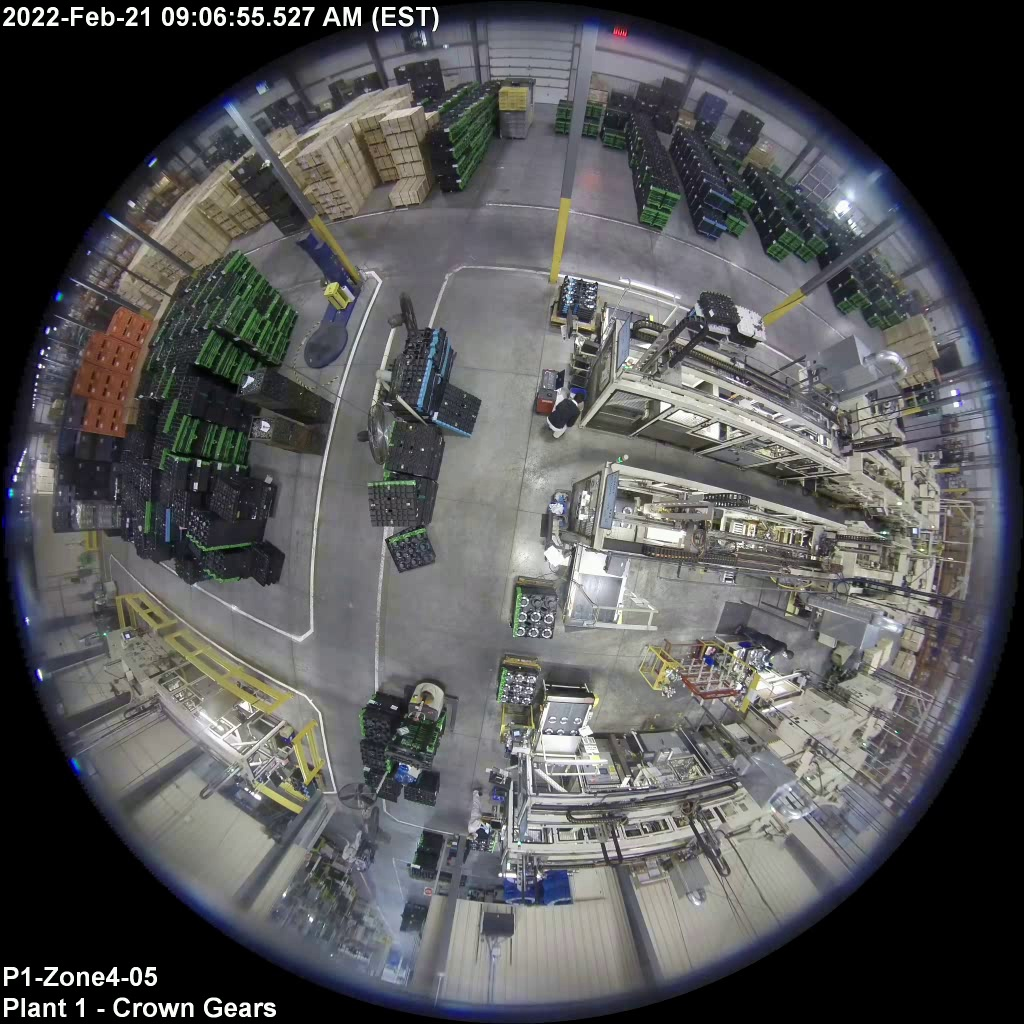

In [157]:
frame = 4110
image = cv2.imread('/content/drive/MyDrive/Machine learning projects/Human tracking/Frames/Frame' + str(frame) + '.jpg');
cv2_imshow(image)